In [2]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# load dotenv
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if GEMINI_API_KEY is None:
    raise ValueError("GEMINI_API_KEY environment variable not set")

PyTorch version: 2.5.1
Torchvision version: 0.20.1
CUDA available: False


Found 10 test images
  - blue-anchor-station.jpg
  - 47483852.257d1195.640.jpg
  - 3143794763_492df87812_b.jpg
  - test_horse.jpg
  - test_car.jpg
  - bl-cam-640px.jpg
  - download.jpeg
  - images.jpeg
  - download (1).jpeg
  - images (1).jpeg


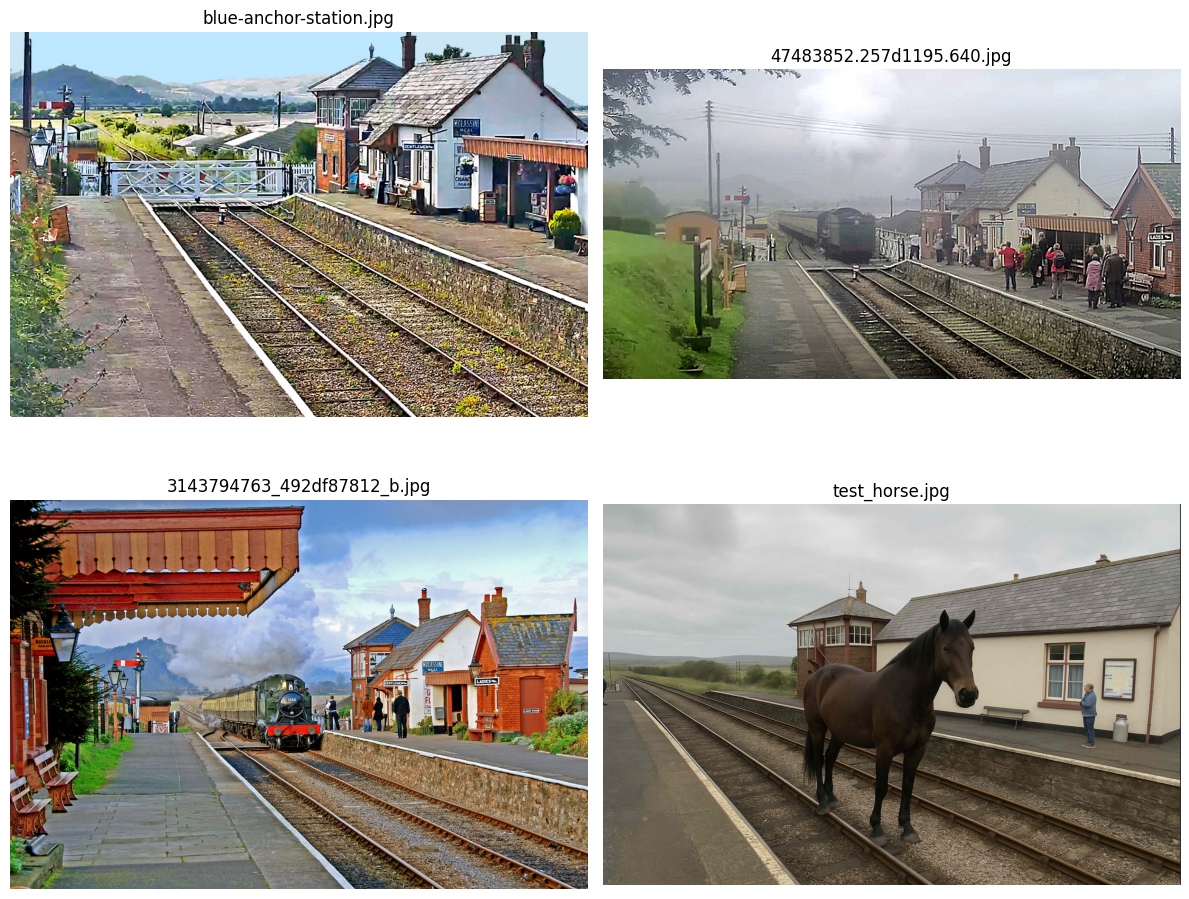

In [3]:
# Load test images
test_images_dir = Path("test_images")
image_files = list(test_images_dir.glob("*.jpg")) + list(test_images_dir.glob("*.jpeg"))

print(f"Found {len(image_files)} test images")
for img_file in image_files:
    print(f"  - {img_file.name}")

# Load and display first few images
def load_and_show_images(image_files, num_images=4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(image_files[:num_images]):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(img_path.name)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

load_and_show_images(image_files)

In [4]:
import re

# Load pre-trained YOLOv5 model (lightweight and good for object detection)
# YOLOv5 can detect 80 different classes including trains
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Set model to evaluation mode
model.eval()

# Get the class names
class_names = model.names
print(f"Model can detect {len(class_names)} classes")
print(f"Train class available: {'train' in [v.lower() for v in class_names.values()]}")

# Show some relevant classes for transportation
transport_keywords = ['train', 'bus', 'car', 'truck', 'person']
transport_classes = {k: v for k, v in class_names.items()
                    if any(re.fullmatch(word, v.lower()) for word in transport_keywords)}
print("\nTransportation-related classes:")
for idx, name in transport_classes.items():
    print(f"  {idx}: {name}")

Using cache found in /Users/michael/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-28 Python-3.11.9 torch-2.5.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Model can detect 80 classes
Train class available: True

Transportation-related classes:
  0: person
  2: car
  5: bus
  6: train
  7: truck


In [5]:
# Function to detect trains in images
def detect_train(image_path, confidence_threshold=0.5):
    """
    Detect if there's a train in the image using YOLOv5
    Returns: (has_train, detections, processed_image)
    """
    # Run inference
    results = model(str(image_path))
    
    # Get predictions
    predictions = results.pandas().xyxy[0]  # Get dataframe of predictions
    
    # Check for trains (class 6 in COCO dataset is 'train')
    train_detections = predictions[predictions['name'] == 'train']
    has_train = len(train_detections) > 0
    
    # Also get high confidence detections of any class
    high_conf_detections = predictions[predictions['confidence'] >= confidence_threshold]
    
    return has_train, train_detections, high_conf_detections, results

# Test on all images
print("="*50)
print("TRAIN DETECTION RESULTS")
print("="*50)

detection_results = []
for img_path in image_files:
    has_train, train_detections, all_detections, results = detect_train(img_path, confidence_threshold=0.3)
    
    detection_results.append({
        'image': img_path.name,
        'has_train': has_train,
        'train_detections': train_detections,
        'all_detections': all_detections,
        'results': results
    })
    
    print(f"\n{img_path.name}:")
    print(f"  Train detected: {'YES ✓' if has_train else 'NO'}")
    
    if has_train:
        for _, detection in train_detections.iterrows():
            print(f"    - Train confidence: {detection['confidence']:.2%}")
    
    if len(all_detections) > 0:
        detected_objects = all_detections['name'].value_counts().to_dict()
        print(f"  Other objects detected: {detected_objects}")

TRAIN DETECTION RESULTS

blue-anchor-station.jpg:
  Train detected: NO
  Other objects detected: {'potted plant': 1}

47483852.257d1195.640.jpg:
  Train detected: YES ✓
    - Train confidence: 76.96%
  Other objects detected: {'person': 8, 'train': 1}

3143794763_492df87812_b.jpg:
  Train detected: YES ✓
    - Train confidence: 87.78%
  Other objects detected: {'person': 4, 'bench': 2, 'train': 1, 'potted plant': 1}

test_horse.jpg:
  Train detected: NO
  Other objects detected: {'person': 2, 'horse': 1, 'bench': 1}

test_car.jpg:
  Train detected: NO
  Other objects detected: {'handbag': 2, 'car': 1, 'bench': 1, 'person': 1}

bl-cam-640px.jpg:
  Train detected: YES ✓
    - Train confidence: 87.75%
  Other objects detected: {'person': 2, 'train': 1, 'car': 1}

download.jpeg:
  Train detected: YES ✓
    - Train confidence: 77.24%
  Other objects detected: {'train': 1, 'person': 1}

images.jpeg:
  Train detected: YES ✓
    - Train confidence: 45.74%
  Other objects detected: {'person': 1


VISUAL RESULTS WITH BOUNDING BOXES


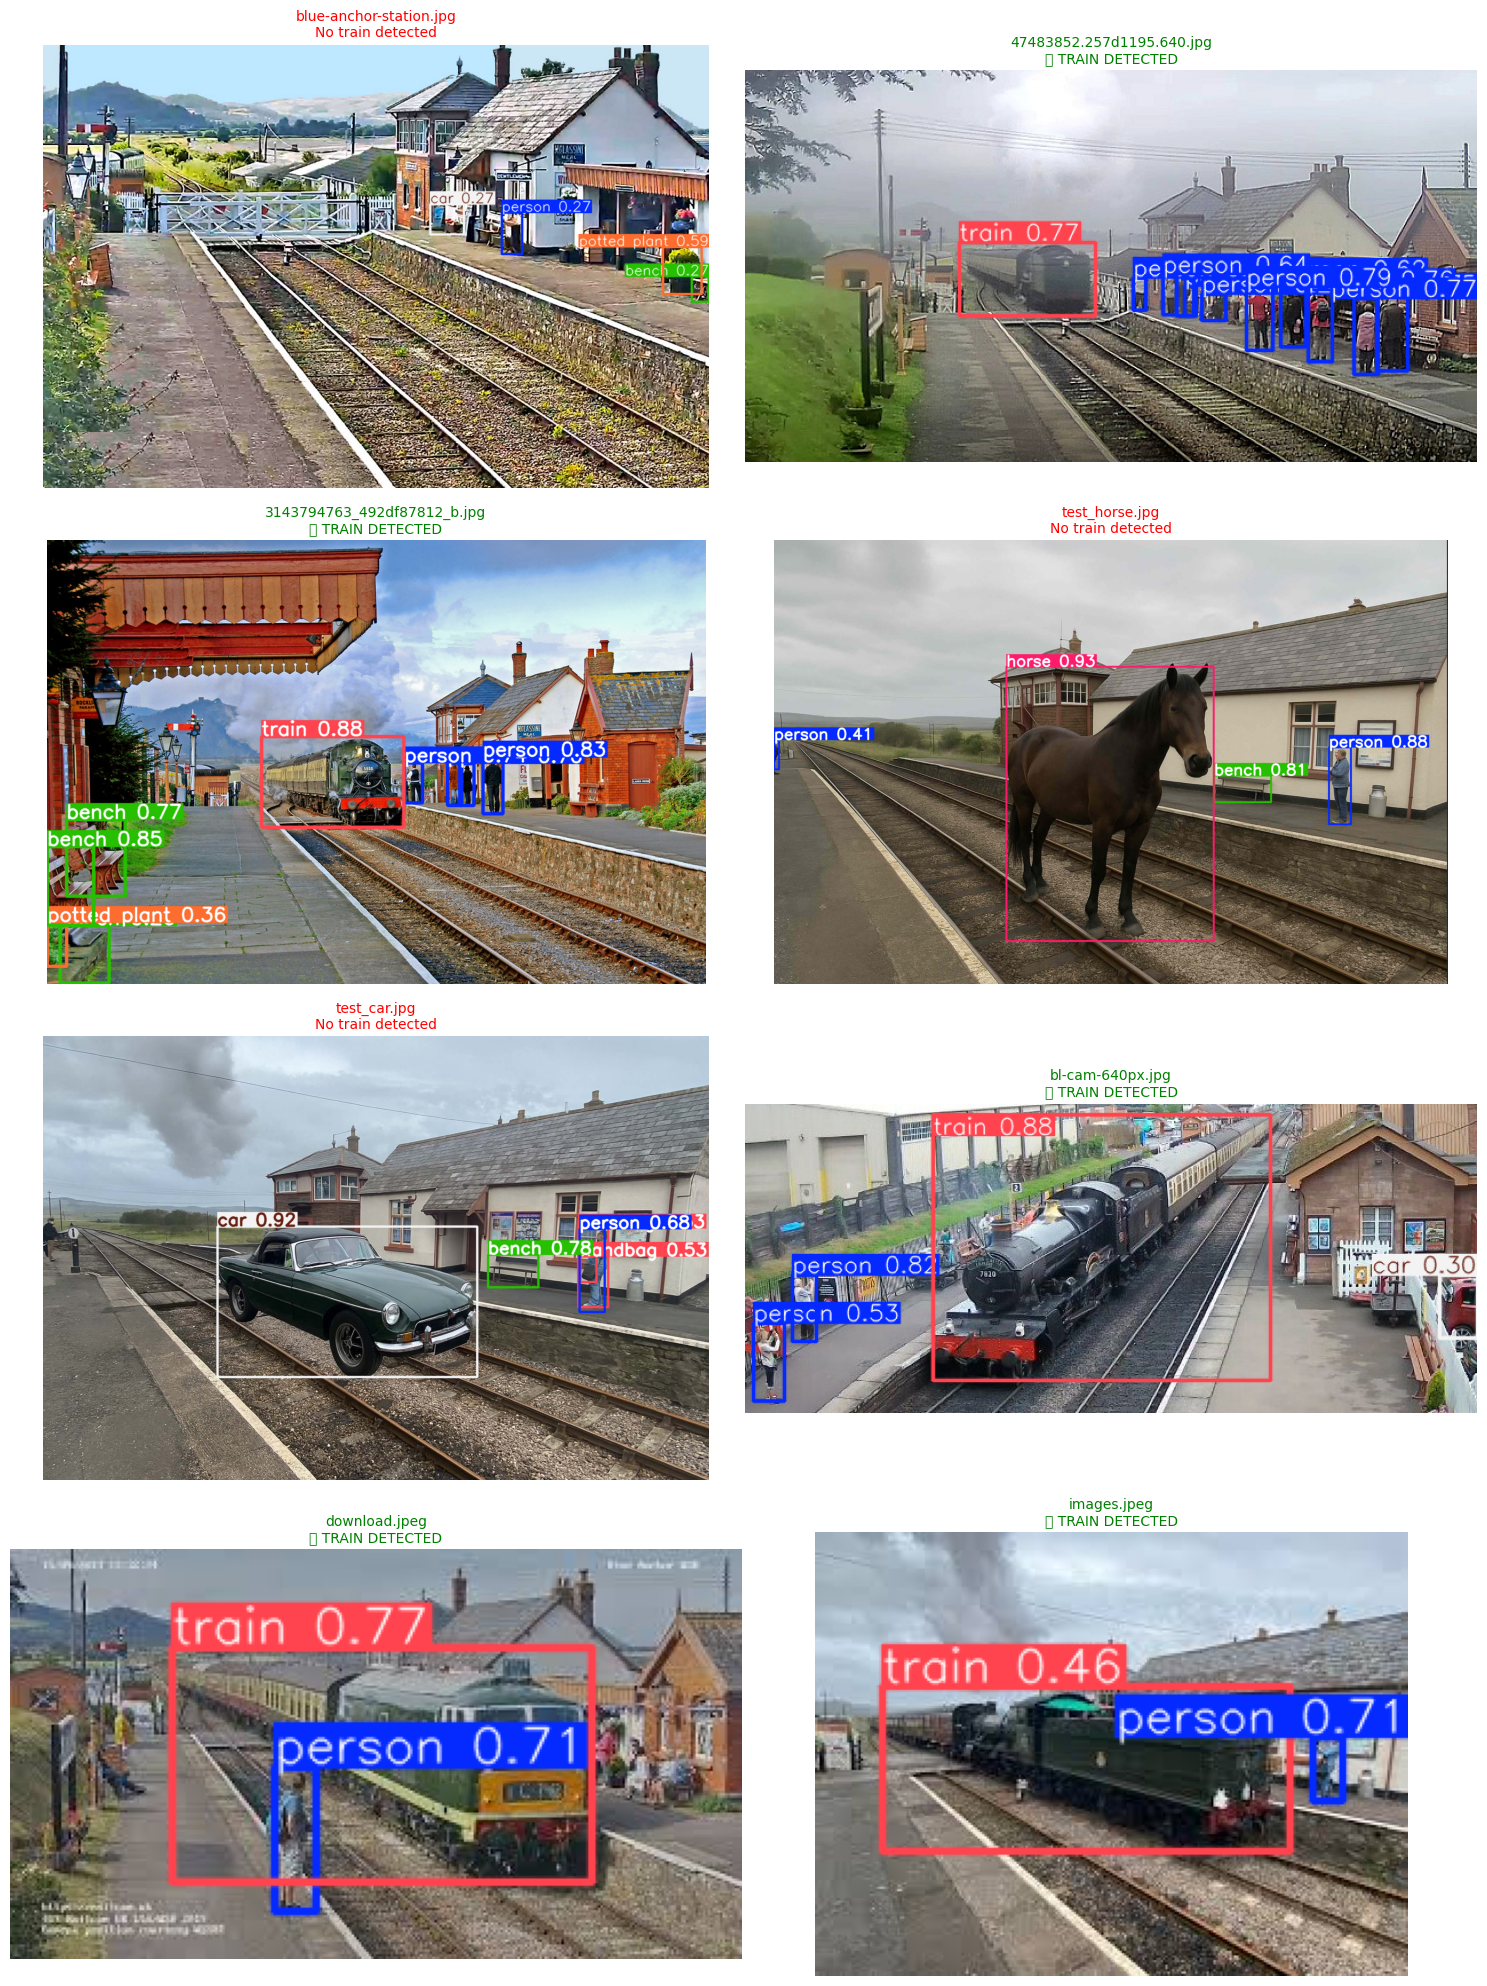

In [ ]:
# Ensure matplotlib displays inline in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize results with bounding boxes
def visualize_detections(detection_results, num_to_show=8):
    """Display images with detection bounding boxes"""
    if not detection_results:
        print("No detection results found. Please run the detection cell first.")
        return
    
    n_images = min(len(detection_results), num_to_show)
    n_cols = 2
    n_rows = (n_images + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_images == 1:
        axes = np.array([[axes]])
    
    for idx, result in enumerate(detection_results[:n_images]):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Render the image with bounding boxes
        rendered_img = result['results'].render()[0]  # Returns numpy array
        ax.imshow(rendered_img)
        
        # Set title with train detection status
        title = f"{result['image']}\n"
        if result['has_train']:
            title += "🚂 TRAIN DETECTED"
        else:
            title += "No train detected"
        
        ax.set_title(title, fontsize=10, color='green' if result['has_train'] else 'red')
        ax.axis('off')
    
    # Hide any unused subplots
    for idx in range(n_images, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_rows > 1:
            axes[row, col].axis('off')
        else:
            axes[col].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("VISUAL RESULTS WITH BOUNDING BOXES")
print("="*50)

# Check if detection_results exists
try:
    visualize_detections(detection_results)
except NameError:
    print("⚠️ Please run the detection cell above first to generate detection_results")

In [ ]:
# Summary statistics
train_count = sum(1 for r in detection_results if r['has_train'])
total_images = len(detection_results)

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Total images analyzed: {total_images}")
print(f"Images with trains detected: {train_count}")
print(f"Images without trains: {total_images - train_count}")
print(f"Detection rate: {train_count/total_images:.1%}")

# Show which images had trains
print("\nImages with trains:")
for result in detection_results:
    if result['has_train']:
        confidence = result['train_detections']['confidence'].max() if len(result['train_detections']) > 0 else 0
        print(f"  ✓ {result['image']} (confidence: {confidence:.2%})")

print("\nImages without trains:")
for result in detection_results:
    if not result['has_train']:
        print(f"  ✗ {result['image']}")


SUMMARY
Total images analyzed: 10
Images with trains detected: 6
Images without trains: 4
Detection rate: 60.0%

Images with trains:
  ✓ 47483852.257d1195.640.jpg (confidence: 76.96%)
  ✓ 3143794763_492df87812_b.jpg (confidence: 87.78%)
  ✓ bl-cam-640px.jpg (confidence: 87.75%)
  ✓ download.jpeg (confidence: 77.24%)
  ✓ images.jpeg (confidence: 45.74%)
  ✓ images (1).jpeg (confidence: 54.83%)

Images without trains:
  ✗ blue-anchor-station.jpg
  ✗ test_horse.jpg
  ✗ test_car.jpg
  ✗ download (1).jpeg


In [ ]:
# Run images tagged as having a train through Gemini LLM (cropped to bounding box, using official SDK)
from google import genai
from google.genai import types
import os
import matplotlib.pyplot as plt
from PIL import Image

# Placeholder for Gemini API key

def run_gemini_on_train_images(detection_results, api_key, model="gemini-2.5-flash"):
    """
    detection_results: iterable of dicts like {"image": "file.jpg", "has_train": True/False}
    Returns: list of {"image": <str>, "text": <str>, "raw": <API response object>}
    """
    client = genai.Client(api_key=api_key)
    out = []
    for result in detection_results:
        if not result.get("has_train") or len(result['train_detections']) == 0:
            continue
        img_path = os.path.join("test_images", result["image"])
        orig_img = Image.open(img_path).convert("RGB")
        for _, detection in result['train_detections'].iterrows():
            xmin, ymin, xmax, ymax = map(int, [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']])
            cropped_img = orig_img.crop((xmin, ymin, xmax, ymax))
            # Show screenshot for checking
            plt.figure(figsize=(4,4))
            plt.imshow(cropped_img)
            plt.title(f"{result['image']} - Train bbox")
            plt.axis('off')
            plt.show()
            # Convert cropped image to bytes
            import io
            buf = io.BytesIO()
            cropped_img.save(buf, format='JPEG')
            image_bytes = buf.getvalue()
            resp = client.models.generate_content(
                model=model,
                contents=[
                    types.Part.from_bytes(data=image_bytes, mime_type="image/jpeg"),
                    "Describe the scene. Confirm if a train is present and note any visible features. Also try and classify the type of train if possible.",
                ],
            )
            out.append({"image": result["image"], "bbox": [xmin, ymin, xmax, ymax], "text": resp.text, "raw": resp})
    return out

# Example usage (uncomment to run):


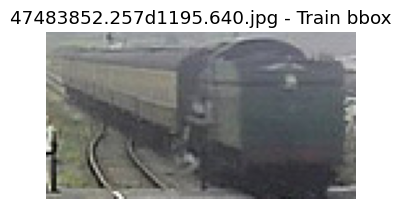

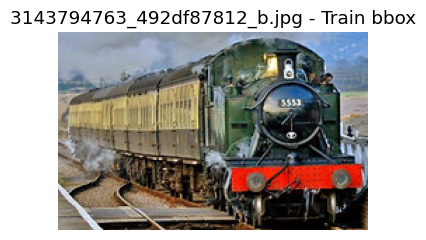

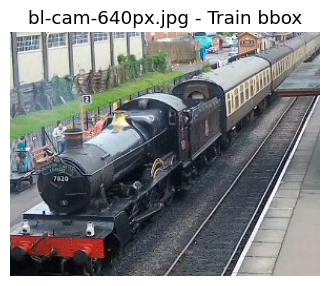

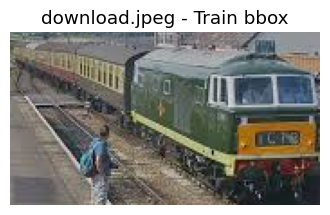

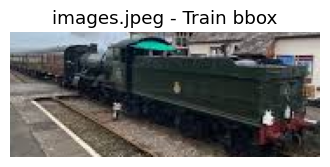

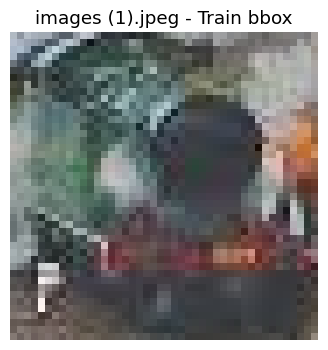

In [ ]:
gemini_results = run_gemini_on_train_images(detection_results, GEMINI_API_KEY)

In [ ]:
gemini_results

[{'image': '47483852.257d1195.640.jpg',
  'bbox': [187, 151, 306, 215],
  'text': 'The scene depicts a railway setting, with a train prominently featured on multiple tracks.\n\n**Confirmation of Train Presence:**\nYes, a train is definitely present in the image.\n\n**Visible Features:**\n\n*   **The Train:**\n    *   **Locomotive:** The train is headed by what appears to be a large, dark-colored (likely deep green or black) **steam locomotive**. It has a distinctly **streamlined or semi-streamlined front end**, giving it an aerodynamic appearance with a rounded or tapered nose, typical of high-speed express locomotives. The top of the locomotive seems to curve back smoothly. There is a prominent headlamp or number plate area on the very front, though details are illegible due to blurriness.\n    *   **Coaches:** Behind the locomotive, there is a long line of multiple passenger coaches, also appearing to be dark green, consistent with the locomotive\'s livery. They are traditional recta